In [1]:
import sys
import json
from IPython import display
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# parent directory to work with dev
sys.path.insert(0, '..')
import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_card_toolkit.utils.tally_form import tally_form_to_mc
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
    Perturbation,
    SHAPFeatureImportance,
    FeatureImportance,
    DataShift
)

## Read sample dataset and create ML model

In [2]:
# Credit score dataset
df = pd.read_csv("../data/credit_risk.csv")
df = df.fillna(method='backfill').dropna()
x = df.drop(["credit_risk",], axis=1)
y = df["credit_risk"]

# Train-Test data Split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=89
)


## Build ML model with protected attributes as model features

# Apply one hot encoding to categorical columns (auto-detect object columns) and random forest model in the pipeline
estimator = Pipeline(steps=[('onehot', ce.OneHotEncoder(use_cat_names=True)),
                      ('classifier', RandomForestRegressor(random_state=99)
                      )])


# Fit, predict and compute performance metrics
estimator.fit(x_train, y_train)

output = x_test.copy() # x_test df with output columns, to be appended later
y_pred = estimator.predict(x_test)
train_pred = estimator.predict(x_train)

mse_train = round(mean_squared_error(y_train, train_pred),3)
r2_train = round(r2_score(y_train, train_pred), 3)
mse_test = round(mean_squared_error(y_test, y_pred),3)
r2_test = round(r2_score(y_test, y_pred), 3)


# Add output columns to this dataframe, to be used as a input for feat tests
output["truth"] = y_test
output["prediction"] = y_pred

# Dataframe with categorical features encoded
x_train_encoded = estimator[0].transform(x_train)
x_test_encoded = estimator[0].transform(x_test)


# Get feature importance values
df_importance = pd.DataFrame(
    {"features": x_test_encoded.columns, "value": estimator[-1].feature_importances_}
)

## Get fitted values vs actual plot on train/test set

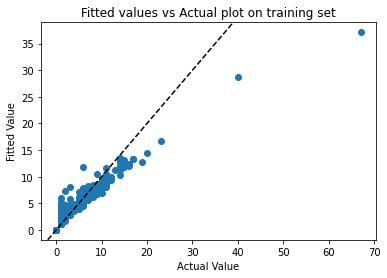

In [3]:
# Train set
plt.axline((1, 1), linestyle='--', color='black', slope=1)
plt.scatter(y_train, train_pred)
plt.xlabel('Actual Value')
plt.ylabel('Fitted Value')
plt.title('Fitted values vs Actual plot on training set')
fitted_vs_actual_plot_train = plot_to_str()


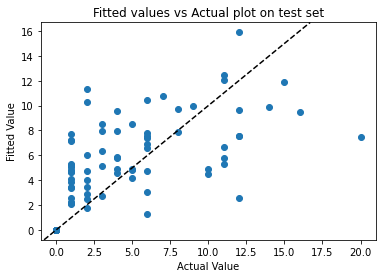

In [4]:
# Test set
plt.axline((1, 1), linestyle='--', color='black', slope=1)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Value')
plt.ylabel('Fitted Value')
plt.title('Fitted values vs Actual plot on test set')
fitted_vs_actual_plot_test = plot_to_str()


## Analysing model perfomance

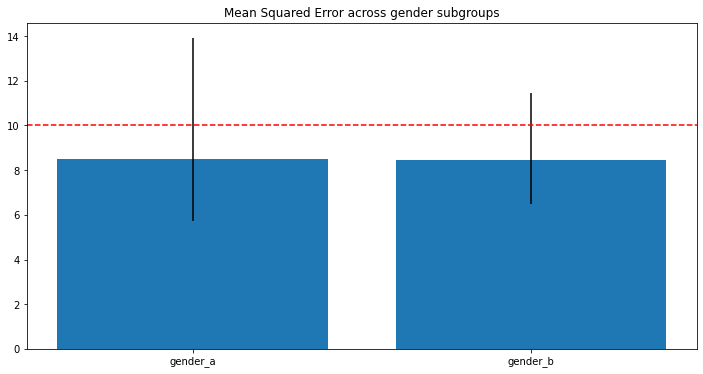

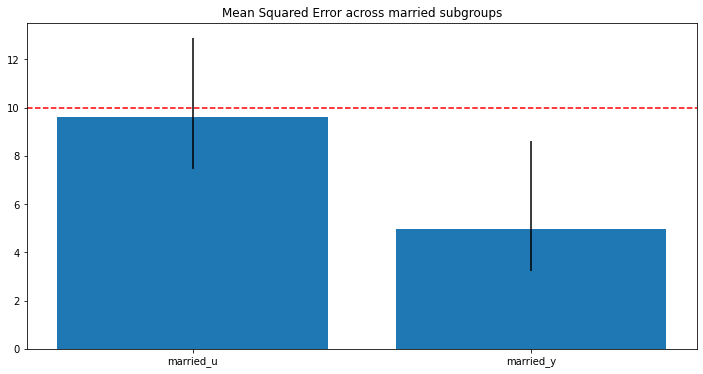

In [5]:
# ROC/Min Max Threshold Test

tpr_threshold_test_gender = MinMaxMetricThreshold(
    #test_name="",        # Default test name and description will be used accordingly if not specified
    #test_desc="",
    attr="gender",
    metric="mse",
    threshold=10,
)
tpr_threshold_test_gender.run(df_test_with_output=output)
tpr_threshold_test_gender.plot(alpha=0.05)

tpr_threshold_test_married = MinMaxMetricThreshold(
    attr="married",
    metric="mse",
    threshold=10,
)
tpr_threshold_test_married.run(df_test_with_output=output)
tpr_threshold_test_married.plot(alpha=0.05)

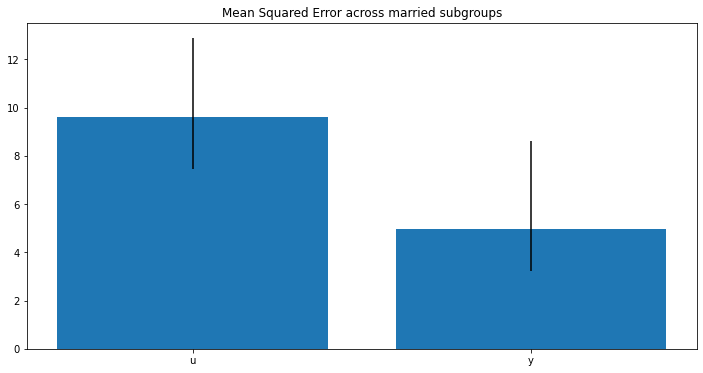

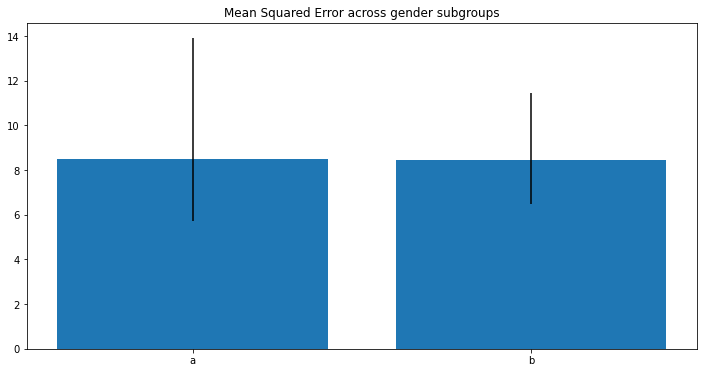

In [6]:
# Subgroup Disparity Test

sgd_test_married = SubgroupDisparity(
    attr='married',
    metric='mse',
    method='ratio',
    threshold=1.5,
)
sgd_test_married.run(output)
sgd_test_married.plot(alpha=0.05)     # default alpha argument shows 95% C.I bands

sgd_test_gender = SubgroupDisparity(
    attr='gender',
    metric='mse',
    method='ratio',
    threshold=1.5,
)
sgd_test_gender.run(output)
sgd_test_gender.plot(alpha=0.05)    # default alpha argument shows 95% C.I bands

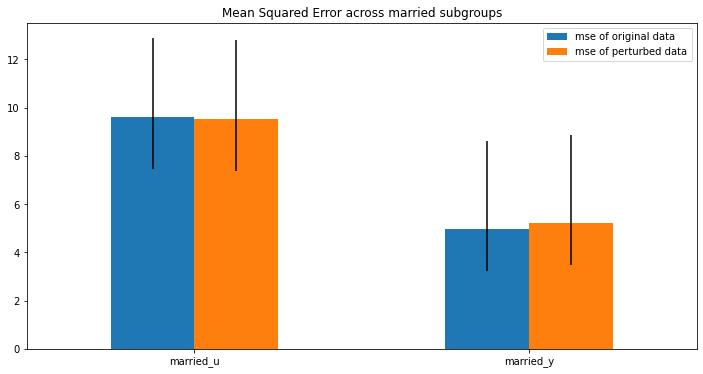

In [7]:
# Subgroup Perturbation Test

np.random.seed(123)
pmt_test = Perturbation(
    attr='married',
    metric='mse',
    method='ratio',
    threshold=1.5,
    #proba_threshold=0.55,  #outcome probability threshold, default at 0.5
)

pmt_test.run(
    x_test=x_test,
    y_test=y_test,
    encoder=estimator[0],
    model=estimator[-1]
)

pmt_test.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands

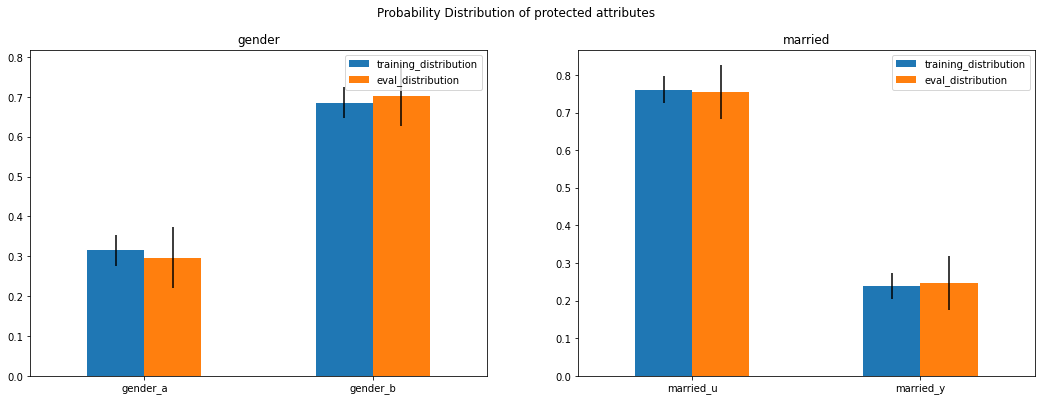

In [8]:
# Data distribution Shift Test

shift_test = DataShift(
    protected_attr = ['gender','married'],
    method = 'chi2',
    threshold = 0.05
)

shift_test.run(x_train = x_train, x_test = x_test)
shift_test.plot(alpha=0.05)   # default alpha argument shows 95% C.I bands

## Model explainability

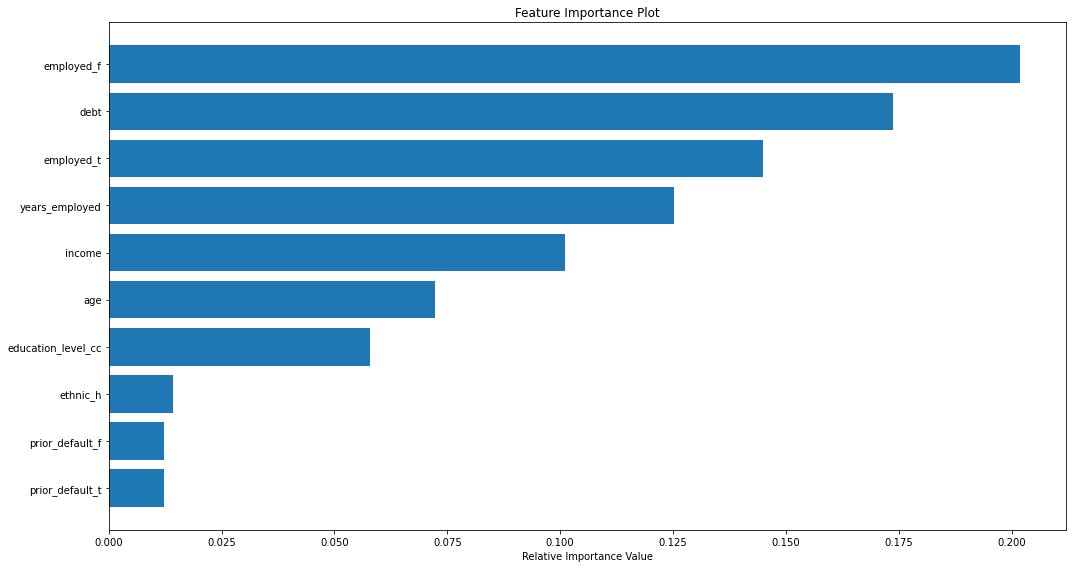

In [9]:
imp_test = FeatureImportance(
    attrs=['gender','married'],
    threshold=5
)

imp_test.run(df_importance)
imp_test.plot(df_importance, show_n=10)   # Show top 10 most important features

model_output = "margin" has been renamed to model_output = "raw"


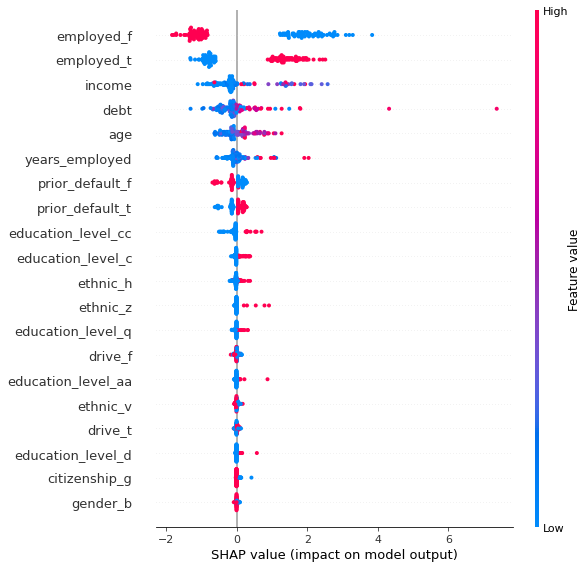

In [10]:
# Shapely Importance Features Test

shap_test = SHAPFeatureImportance(
    attrs=['gender','married'],
    threshold=10
)

shap_test.run(
    model=estimator[-1],
    model_type='trees',
    x_train_encoded=x_train_encoded,
    x_test_encoded=x_test_encoded,
)
shap_test.shap_summary_plot(x_test_encoded)
shap_test.shap_dependence_plot(x_test_encoded, show_all=False) # Show only dependence plots of attributes that failed the test

## Bootstrap model card from tally form and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the tally form response.

We will add a true positive rate threshold test to ensure a reasonable model perfomance and a false positive rate disparity test to ensure it does not discriminate across gender or marital status.

In [11]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response-credit-risk-regression.json")

# Initialize the mct and scaffold using the existing protobuf
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="credit_risk_regression_example")
mc = mct.scaffold_assets(proto=pb)
mc.model_details.name = "Credit Risk Model"

## Convert test objects to a model-card-compatible format

In [12]:
# init model card test objects
mc_tpr_threshold_test_gender = mctlib.Test()
mc_tpr_threshold_test_married = mctlib.Test()
mc_sgd_test_married = mctlib.Test()
mc_sgd_test_gender = mctlib.Test()
mc_pmt_test = mctlib.Test()
mc_shap_test = mctlib.Test()
mc_shift_test = mctlib.Test()

# assign tests to them
mc_tpr_threshold_test_gender.read_model_test(tpr_threshold_test_gender)
mc_tpr_threshold_test_married.read_model_test(tpr_threshold_test_married)
mc_sgd_test_married.read_model_test(sgd_test_married)
mc_sgd_test_gender.read_model_test(sgd_test_gender)
mc_pmt_test.read_model_test(pmt_test)
mc_shap_test.read_model_test(shap_test)
mc_shift_test.read_model_test(shift_test)

In [13]:
# Add quantitative analysis

# Create 4 PerformanceMetric to store our results
mc.quantitative_analysis.performance_metrics = [mctlib.PerformanceMetric() for i in range(0, 5)]
mc.quantitative_analysis.performance_metrics[0].type = "R2"
mc.quantitative_analysis.performance_metrics[0].value = str(r2_train)
mc.quantitative_analysis.performance_metrics[0].slice = "Training Set"

mc.quantitative_analysis.performance_metrics[1].type = "MSE"
mc.quantitative_analysis.performance_metrics[1].value = str(mse_train)
mc.quantitative_analysis.performance_metrics[1].slice = "Training Set"
mc.quantitative_analysis.performance_metrics[1].graphics.description = (
  'Fitted Values vs Actual plot')
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=fitted_vs_actual_plot_train)
]

mc.quantitative_analysis.performance_metrics[2].type = "R2"
mc.quantitative_analysis.performance_metrics[2].value = str(r2_test)
mc.quantitative_analysis.performance_metrics[2].slice = "Test Set"

mc.quantitative_analysis.performance_metrics[3].type = "MSE"
mc.quantitative_analysis.performance_metrics[3].value = str(mse_test)
mc.quantitative_analysis.performance_metrics[3].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[3].graphics.description = (
  'Fitted Values vs Actual plot')
mc.quantitative_analysis.performance_metrics[3].graphics.collection = [
    mctlib.Graphic(image=fitted_vs_actual_plot_test)
]

mc.quantitative_analysis.performance_metrics[4].type = "True positive rate"
mc.quantitative_analysis.performance_metrics[4].tests = [mc_tpr_threshold_test_gender, mc_tpr_threshold_test_married]

In [14]:
# You can add the components of a test (e.g. on explainability) in a report
mc.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(
        type="Top 10 most important features", graphics=mctlib.GraphicsCollection(
            collection = [mctlib.Graphic(name=n, image=i) for n, i in imp_test.plots.items()]
        )
    )
]

# Or you can add it as a test directly
mc.explainability_analysis.explainability_reports.append(
    mctlib.ExplainabilityReport(type="Protected Attributes should not be model's top important features", tests=[mc_shap_test])
)

In [15]:
# Add the fairness requirement for subgroup disparity
mc.fairness_analysis.fairness_reports[0].tests = [mc_sgd_test_married, mc_sgd_test_gender]

# We also add a test for attribute shift between the training and testing dataset for additional reliablity check
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type="Distribution of attribute subgroups should be silimiar across different datasets", tests=[mc_shift_test])
)
mc.fairness_analysis.fairness_reports.append(
    mctlib.FairnessReport(type='Fairness metric for subgroups in original data and perturbed data should be similar', tests=[mc_pmt_test])
)

mct.update_model_card(mc)

## Model Card Display

In [16]:
# Export to html
html = mct.export_format(output_file="credit_risk_regression_example.html")
display.display(display.HTML(html))

,mse,passed
gender_a,8.491,True
gender_b,8.453,True
,mse,passed
married_u,9.605,True
married_y,4.977,True
,feature_rank,passed
gender_b,20.0,True
gender_a,22.0,True
married_y,28.0,True
married_u,29.0,True
